# CS3920 Assessed Coursework

## Assignment 2

### 1. Load the datasets

In [1]:
import numpy as np, matplotlib, math
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
wine_dataset = load_wine()
USPS_train = np.genfromtxt("zip.train", delimiter=" " , dtype=float)
USPS_test = np.genfromtxt("zip.train", delimiter=" " ,dtype=float)
USPS_dataset = np.vstack((USPS_train, USPS_test))

USPS_labels = USPS_dataset[:,0].astype(int)
USPS_features = USPS_dataset[:,1:]

### 2. Divide datasets into training and test sets

In [3]:
wine_training_features, wine_testing_features, wine_training_labels, wine_testing_labels = train_test_split(wine_dataset['data'], wine_dataset['target'], random_state=3010)

USPS_training_features, USPS_testing_features, USPS_training_labels, USPS_testing_labels = train_test_split(USPS_features, USPS_labels, random_state=3010)

### 3. Estimate generalisation accuracy of SVM using cross validation

In [4]:
from sklearn.svm import SVC

svm_classifier = SVC()

wine_cv_scores = cross_val_score(svm_classifier, wine_training_features, wine_training_labels)
USPS_cv_scores = cross_val_score(svm_classifier, USPS_training_features, USPS_training_labels)

wine_cv_accuracy = wine_cv_scores.mean()
USPS_cv_accuracy = USPS_cv_scores.mean()

print(f"Wine Dataset - Cross-Validation Accuracy: {wine_cv_accuracy:.4f}")
print(f"USPS Dataset - Cross-Validation Accuracy: {USPS_cv_accuracy:.4f}")


Wine Dataset - Cross-Validation Accuracy: 0.6989
USPS Dataset - Cross-Validation Accuracy: 0.9868


### 4. Find the test error rate of the SVM

In [6]:
from sklearn.metrics import accuracy_score

#fit SVM to training set
svm_classifier.fit(wine_training_features, wine_training_labels)
wine_test_predictions = svm_classifier.predict(wine_testing_features)

svm_classifier.fit(USPS_training_features, USPS_training_labels)
USPS_test_predictions = svm_classifier.predict(USPS_testing_features)

# Calculate test error rates
wine_test_accuracy = accuracy_score(wine_testing_labels, wine_test_predictions)
USPS_test_accuracy = accuracy_score(USPS_testing_labels, USPS_test_predictions)

wine_test_error_rate = 1 - wine_test_accuracy
USPS_test_error_rate = 1 - USPS_test_accuracy

print(f"Wine Dataset - Test Accuracy: {wine_test_accuracy:.4f}, Test Error Rate: {wine_test_error_rate:.4f}")
print(f"USPS Dataset - Test Accuracy: {USPS_test_accuracy:.4f}, Test Error Rate: {USPS_test_error_rate:.4f}")


Wine Dataset - Test Accuracy: 0.6889, Test Error Rate: 0.3111
USPS Dataset - Test Accuracy: 0.9929, Test Error Rate: 0.0071


Comparing the estimates to the actual test error rates, there was a difference of only 1% or less in both datasets. \
This suggests the SVM model is performing consistently and is not overfitting. 

### 5. Create a pipeline to tune C and Gamma, and experiment with normalisation techniques

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid = {
    'scaler':[StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
    },
    n_jobs=-1,
    scoring = 'accuracy'
)

grid_search.fit(wine_training_features, wine_training_labels)
wine_best_params = grid_search.best_params_
wine_best_score = grid_search.best_score_

grid_search.fit(USPS_training_features, USPS_training_labels)
USPS_best_params = grid_search.best_params_
USPS_best_score = grid_search.best_score_

print(f"Wine Dataset - Best Params: {wine_best_params}, Best Cross-Validation Accuracy: {wine_best_score:.4f}")
print(f"USPS Dataset - Best Params: {USPS_best_params}, Best Cross-Validation Accuracy: {USPS_best_score:.4f}")

Wine Dataset - Best Params: {'scaler': StandardScaler(), 'svm__C': 10, 'svm__gamma': 0.01}, Best Cross-Validation Accuracy: 0.9923
USPS Dataset - Best Params: {'scaler': Normalizer(), 'svm__C': 100, 'svm__gamma': 1}, Best Cross-Validation Accuracy: 0.9920


### 6. Fit GridSearchCV to training set, predict labels and calculate test error rate

In [11]:
grid_search.fit(wine_training_features, wine_training_labels)
wine_test_predictions = grid_search.best_estimator_.predict(wine_testing_features)

grid_search.fit(USPS_training_features, USPS_training_labels)
USPS_test_predictions = grid_search.best_estimator_.predict(USPS_testing_features)

wine_test_accuracy = accuracy_score(wine_testing_labels, wine_test_predictions)
wine_test_error_rate = 1 - wine_test_accuracy

USPS_test_accuracy = accuracy_score(USPS_testing_labels, USPS_test_predictions)
USPS_test_error_rate = 1 - USPS_test_accuracy

print(f"Wine Dataset - Best Test Accuracy: {wine_test_accuracy:.4f}, Test Error Rate: {wine_test_error_rate:.4f}")
print(f"USPS Dataset - Best Test Accuracy: {USPS_test_accuracy:.4f}, Test Error Rate: {USPS_test_error_rate:.4f}")

Wine Dataset - Best Test Accuracy: 0.9556, Test Error Rate: 0.0444
USPS Dataset - Best Test Accuracy: 0.9962, Test Error Rate: 0.0038


### 7. Cross-Conformal Predictor Implementation

In [18]:
from sklearn.model_selection import KFold
import numpy as np
import math

# custom conformity score calculation, adapted from Assignment 1
def calc_conformity_score(training_features, training_labels, test_sample, test_label):
    same_class_dist = math.inf
    diff_class_dist = math.inf

    # iterate over all samples in the training set
    for i in range(len(training_features)):
        distance = np.linalg.norm(test_sample - training_features[i])

        # update the shortest distance for the same or different class
        if training_labels[i] == test_label and distance < same_class_dist and distance != 0:
            same_class_dist = distance
        elif training_labels[i] != test_label and distance < diff_class_dist:
            diff_class_dist = distance

    # handle division by zero
    if same_class_dist == 0:
        if diff_class_dist == 0:
            return 0
        return math.inf
    else:
        return diff_class_dist / same_class_dist


def CCP(X_train, y_train, X_test, labels, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=3010)
    p_values = []

    for x_test in X_test:
        test_p_values = {}

        for postulated_label in labels:
            fold_conformity_scores = []

            # iterate over folds
            for train_idx, valid_idx in kf.split(X_train):
                fold_X_train, fold_y_train = X_train[train_idx], y_train[train_idx]
                fold_X_valid, fold_y_valid = X_train[valid_idx], y_train[valid_idx]

                test_conformity_score = calc_conformity_score(fold_X_train, fold_y_train, x_test, postulated_label)

                # compute ranks within the validation set
                for i in range(len(fold_X_valid)):
                    validation_score = calc_conformity_score(fold_X_train, fold_y_train, fold_X_valid[i], fold_y_valid[i])
                    if validation_score <= test_conformity_score:
                        fold_conformity_scores.append(1)  # rank increment
                fold_conformity_scores.append(1)  # include the test sample rank

            # compute p-value for the postulated label
            test_p_values[postulated_label] = (np.sum(fold_conformity_scores)) / (len(X_train) + 1)

        p_values.append(test_p_values)

    return p_values


### Compute average false p-values

In [19]:
def average_false_p_value(p_values, test_labels):
    false_values = []

    #iterate over p-value list and corresponding test labels
    for p_values, true_label in zip(p_values, test_labels):
        for label, p_value in p_values.items():
        
            #consider value only if it is false
            if label != true_label:
                false_values.append(p_value)

    return np.mean(false_values)


### Draw callibration curve

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_calibration_curve(p_values, true_labels, dataset):

    eps = np.linspace(0, 1, 100)  # range of significance levels
    err = np.zeros(100)  # corresponding error rates

    for k, threshold in enumerate(eps):
        errors = 0
        for i, test_p_values in enumerate(p_values):
            # check if the true label's p-value is below the threshold
            if test_p_values[true_labels[i]] <= threshold:
                errors += 1 
        # calculate the error rate at this threshold
        err[k] = errors / len(true_labels)

    # Plot the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(eps, err, label="Calibration Curve", color="blue", linewidth=2)
    plt.xlabel("Significance Level (ε)", fontsize=12)
    plt.ylabel("Error Rate", fontsize=12)
    plt.title("Calibration Curve for " + dataset, fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

### Apply to datasets

Average false p-value for Wine data set: 0.124


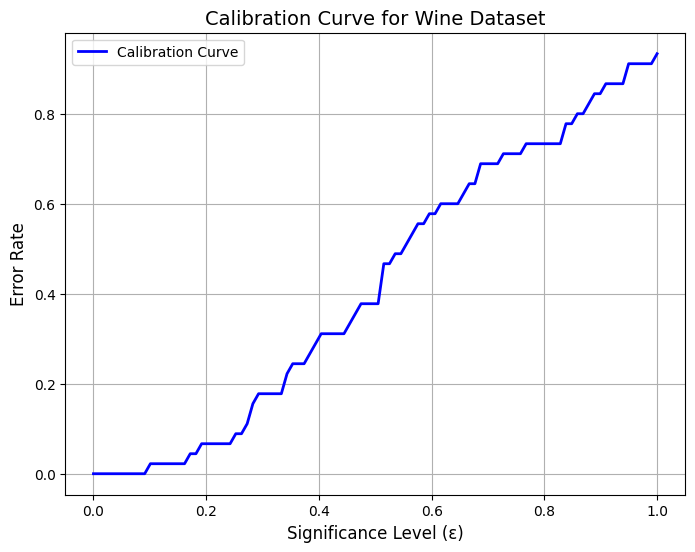

In [26]:
wine_labels = np.unique(wine_training_labels)  
USPS_labels = np.unique(USPS_training_labels)  

wine_p_values = CCP(wine_training_features, wine_training_labels, wine_testing_features, wine_labels)
print(f"Average false p-value for Wine data set: {average_false_p_value(wine_p_values, wine_testing_labels):.3f}")
plot_calibration_curve(wine_p_values, wine_testing_labels, "Wine Dataset")

For the USPS dataset, I was unable to get the code to complete running in time (over 4 hours) due to the large amount of data. \
I have tried parallelisation, but could not get it to run without crashing. \
Instead, I have opted to use a reduced dataset to at least see the output of the CCP

Average false p-value for USPS data set: 0.009


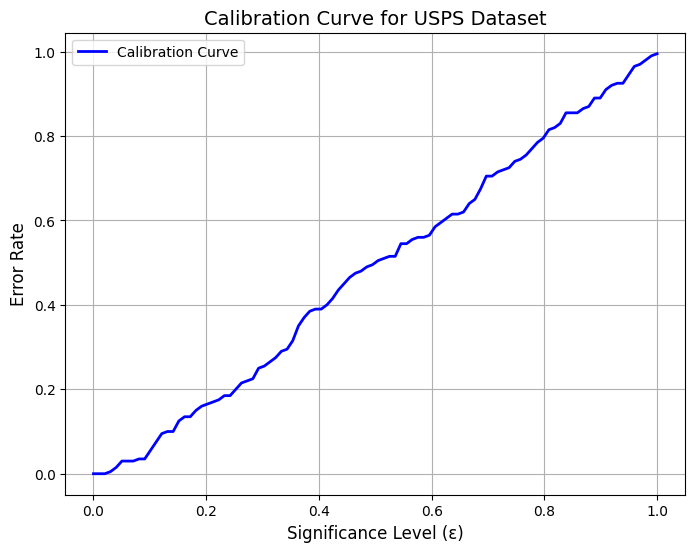

In [27]:
# randomly sample a subset of the training and testing datasets
USPS_training_features_reduced, _, USPS_training_labels_reduced, _ = train_test_split(
    USPS_training_features, USPS_training_labels, train_size=1000, random_state=3010, stratify=USPS_training_labels
)

USPS_testing_features_reduced, _, USPS_testing_labels_reduced, _ = train_test_split(
    USPS_testing_features, USPS_testing_labels, train_size=200, random_state=3010, stratify=USPS_testing_labels
)

USPS_p_values = CCP(USPS_training_features_reduced, USPS_training_labels_reduced, USPS_testing_features_reduced, np.unique(USPS_training_labels_reduced))
print(f"Average false p-value for USPS data set: {average_false_p_value(USPS_p_values, USPS_testing_labels_reduced):.3f}")
plot_calibration_curve(USPS_p_values, USPS_testing_labels_reduced, "USPS Dataset")